# Active contour using level sets
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\norm}[1]{\|#1\|}$



In the level set formalism, the evolution of some curve $ (\gamma(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\gamma(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$


In [1]:
from IPython.core.display import HTML
HTML(open("./custom_nb.css", "r").read())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import ndimage
import pylab
from skimage.color import rgb2gray
from copy import deepcopy

In [ ]:
!pip install tqdm

In [3]:
from tqdm import tqdm

# Functions

In [4]:
def plot_levelset(Z, level=0, f=[]):
    """
    f is supposed to be of the same shape as Z
    f, Z : (nr,nc)
    Plot contour Z, on he same plot as the original image f, and print level of value 0 in red.
    """
    if len(f) == 0:
        f = np.copy(Z)
        
    n,p = np.shape(Z)
    X,Y = np.meshgrid(np.arange(0,p),np.arange(0,n))
    plt.contour(X, Y, Z,[level],linewidths=2, colors="red")
    imgplot = plt.imshow(f, interpolation='nearest')
    imgplot.set_cmap('gray')
    pylab.axis('off')
    
  

# Importation of images

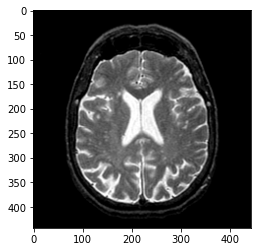

In [5]:
anchor = mpimg.imread('Images/anchor.jpg') 
cortex = (mpimg.imread('Images/cortex.bmp'))
I = cortex
I_gray = rgb2gray(I)
nr,nc= I_gray.shape
plt.imshow(I_gray,cmap='gray')

# Mean curvature motion

The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\gamma'(s)} d s. $$



It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spatial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step.

And Maximum time of the evolution $0 \leq t \leq t_{\max}$.

This first method allows you to implement important functions you will need in Geodesic Active Contour part, and code the core of the full algorithm. \
But here, as the algorithm does not take into account the image during the minimization process, you consider that your initial $\phi^0$ is $I_0$.


In [56]:
def grad(phi,v=2):
    #Apparently backward euler is enough for this task
    #central differences for gradient image
    if v==1:
        nr,nc = phi.shape
        gx = np.zeros((nr,nc))
        gy = np.zeros((nr,nc))
        gx[1:] = phi[1:] - phi[:-1]
        gy[:,1:] = phi[:,1:] - phi[:,:-1]
    
    else:
        nr,nc = phi.shape
        padx = np.array([np.zeros(nc)]) 
        pady = np.array([np.zeros(nr)])

        paddedx1 = np.concatenate((phi[1:,:],padx))
        paddedx2 = np.concatenate((padx,phi[:-1,:]))
        gx = (paddedx1-paddedx2)/2.

        paddedy1 = np.hstack((phi[:,1:],pady.T))
        paddedy2 = np.hstack((pady.T,phi[:,:-1]))
        gy = (paddedy1-paddedy2)/2.
        
    return gx,gy

def div(gx,gy,v=2):
    gxx,_ = grad(gx,v=2)
    _,gyy = grad(gy,v=2)
    
    return gxx+gyy

def G(Phi,v=2):
    
    #we compute here the function G
    nr,nc = Phi.shape
    g_phix,g_phiy = grad(Phi,v)
    n_phi = np.sqrt(g_phix**2+g_phiy**2)
    eps = 10E-10
    #to avoid division by 0
    n_phi = np.maximum(eps*np.ones((g_phix.shape[0],g_phix.shape[1])),n_phi)
    g_phix, g_phiy = g_phix/n_phi, g_phiy/n_phi

    K = - n_phi*div(g_phix, g_phiy,v)
    return K

In [57]:
def mean_curv(phi0,tau,Tmax,I0,v=2):
    '''
    phi0 : your initial shape, size (nr,nc)
    tau : time step size, > 0, be careful to not have a too big time step !
    Tmax : maximum time of evolution
    I0 : your image to segment
    ------
    returns phi, contour matrix (nr,nc)
    
    '''
    phi = deepcopy(phi0)
    for i in range(int(Tmax//tau)):
        phi = phi - tau*G(phi,v)
    return phi

## Application

In [58]:
nr = 200
nc = 300
Y,X = np.meshgrid(np.arange(1,nc), np.arange(1,nr))
r = nr/4.
c = np.asarray([nc,nc])/4.
phi1 = np.maximum(abs(X-c[0]), abs(Y-c[1])) - r

r = nr/6.
c = np.asarray([nc,nc])/2.
phi2 = np.maximum(abs(X-c[0]), abs(Y-c[1])) - r

phi3 = np.minimum(phi1, phi2)

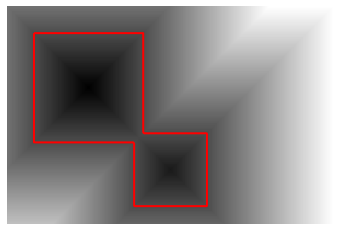

In [59]:
plot_levelset(phi3, 0, phi3)

In [60]:
Tmax = 200
tau = 0.5
phi = mean_curv(phi3,tau,Tmax,None,v=1)

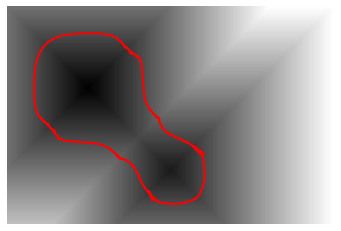

In [61]:
plot_levelset(phi,0,phi3)

In [62]:
Tmax = 200
tau = 0.5
phi = mean_curv(phi3,tau,Tmax,None)

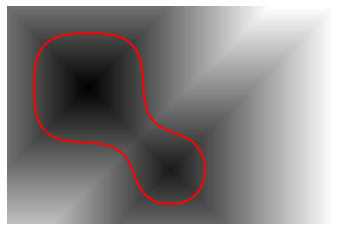

In [63]:
plot_levelset(phi,0,phi3)

##### Remark:
We see a difference in terms of smoothness simply when we change the gradient approximation (without changing the fact that we keep divergence to be 2nd order when it partials for the second time)

# Geodesic Active Contour
Geodesic active contours compute local minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.

Given a background image $I_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of small gradient.


We use here
$$ W(x) = \alpha + \frac{\beta}{\epsilon + d_0(x) }
      \qwhereq d_0(x) = \norm{\nabla I_0(x)} $$




The geodesic active contour minimizes a weighted length of curve
$$ \underset{\gamma}{min} \int_0^1 \norm{\gamma'(s)} W(\gamma(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using a gradient descent scheme.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.




Define an initial $\phi^0$. You can plot it, together with your image I_gray, with plot_levels function.\
Here your $\phi^0$ is not equal to your image $I_0$ !

In [64]:
def grad(phi):
    #central differences for gradient image
    nr,nc = phi.shape
    padx = np.array([np.zeros(nc)]) 
    pady = np.array([np.zeros(nr)])
    
    paddedx1 = np.concatenate((phi[1:,:],padx))
    paddedx2 = np.concatenate((padx,phi[:-1,:]))
    gx = (paddedx1-paddedx2)/2.
    
    paddedy1 = np.hstack((phi[:,1:],pady.T))
    paddedy2 = np.hstack((pady.T,phi[:,:-1]))
    gy = (paddedy1-paddedy2)/2.
    return gx,gy

def div(gx,gy):
    gx,_ = grad(gx)
    _,gy = grad(gy)
    return gx+gy


In [66]:
def initialization_square(I_gray,center,c):
    nr,nc = I_gray.shape
    n = nr
    Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
    phi0 = np.maximum(abs(X-center[0]), abs(Y-center[1])) - c
    return phi0

#optional get rid of this if not writing this TODO
def initialization_circle(center,rad):
    pass

Code here a function to do gradient descent to estimate geodesic active contour.

In [1]:
def geo_curv(phi0,tau,Tmax,I0,W):
    '''
    phi0 : your initial shape, size (nr,nc)
    tau : time step size, > 0, be careful to not have a too big time step !
    Tmax : maximum time of evolution
    I0 : your image to segment
    ------
    returns phi, contour matrix (nr,nc)
    
    '''

    nr,nc = I0.shape
    niter = int(Tmax/tau)
    phi = np.copy(phi0)
    k = 0
    gwx,gwy = grad(W)

    empirical = 10
    for i in tqdm(range(1,niter+1)):
        gx,gy = grad(phi)
        eps = 10E-10
        n_phi = np.maximum(eps*np.ones([nr,nc]), np.sqrt(gx**2+gy**2))
        g_phix,g_phiy = gx/n_phi,gy/n_phi
        G = - W*n_phi*div(g_phix, g_phiy) + gx*gwx + gy*gwy
        phi = phi - tau*G
        
        if (i % 25) == 0:
            phi[-1,:] = eps*empirical #you can  pad to the original image so to have this phi = 0 ignored
            phi[0,:] = eps*empirical
            phi[:,0] = eps*empirical
            phi[:,-1] = eps*empirical
        
    return phi

## Application


In [133]:
padnb = 70

In [ ]:
#We also add padding at the beginning
nr,nc = I_gray.shape
new_I = np.hstack((I_gray,np.zeros((padnb,nr)).T))
new_I = np.concatenate((new_I,np.zeros((padnb,nc+padnb))))

new_I = np.hstack((np.zeros((padnb,nr+padnb)).T,new_I))
nr,nc = new_I.shape
new_I = np.concatenate((np.zeros((padnb,nr+padnb)),new_I))

nr,nc = new_I.shape

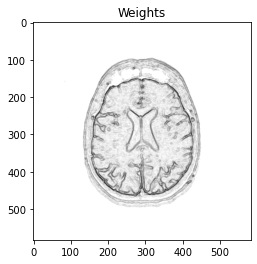

In [136]:
#W computing
alpha = 0.5
beta = 1
epsilon = 0.5


imgx,imgy = grad(new_I)
dmat = np.sqrt(imgx**2+imgy**2)
W = alpha + beta/(epsilon+dmat)

plt.figure()
plt.imshow(W,cmap='gray')
plt.title('Weights')
plt.show()

100%|██████████| 5000/5000 [04:33<00:00, 18.31it/s]


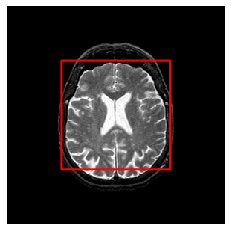

In [140]:
#initialization of starting contour
phi0 = initialization_square(new_I,(nr/2,nr/2),nr/4)
plot_levelset(phi0,0,new_I)

# Play with parameters
Tmax = 2000
tau = 0.4
phi = geo_curv(phi0,tau,Tmax,new_I,W)

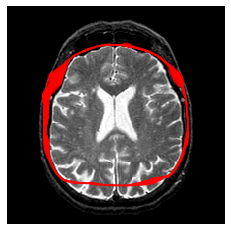

In [141]:
plot_levelset(phi[padnb:-padnb,padnb:-padnb],0,I_gray)

##### Remark:
We notice that we have some overlapping of pixels for the contour, what we can possibly do is to use non max suppression to obtain a thinner contour.

100%|██████████| 5000/5000 [04:50<00:00, 17.21it/s]


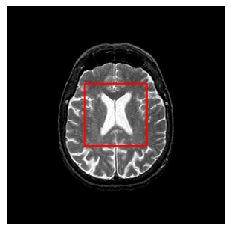

In [142]:
#initialization of starting contour
phi1 = initialization_square(new_I,(nr/2,nr/2),nr/7)
plot_levelset(phi1,0,new_I)

# Play with parameters
Tmax = 2000
tau = 0.4
phi = geo_curv(phi1,tau,Tmax,new_I,W)

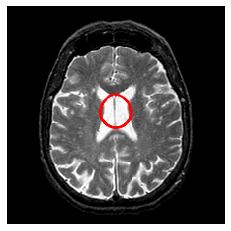

In [143]:
plot_levelset(phi[padnb:-padnb,padnb:-padnb],0,I_gray)

##### Remark:
As we can see here, depending on the initialization, the obtained contour can be very much different

100%|██████████| 5000/5000 [04:33<00:00, 18.28it/s]


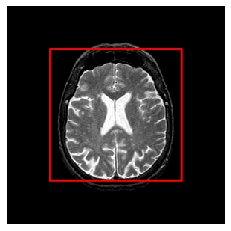

In [144]:
#initialization of starting contour
phi2 = initialization_square(new_I,(nr/2,nr/2),nr/3.3)
plot_levelset(phi2,0,new_I)

# Play with parameters
Tmax = 2000
tau = 0.4
phi = geo_curv(phi2,tau,Tmax,new_I,W)

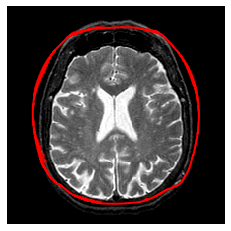

In [145]:
plot_levelset(phi[padnb:-padnb,padnb:-padnb],0,I_gray)

## Conclusion

 13%|█▎        | 628/5000 [00:34<04:01, 18.09it/s]

Plotting ...


 25%|██▌       | 1250/5000 [01:10<05:41, 10.98it/s]

Plotting ...


 38%|███▊      | 1878/5000 [01:43<02:53, 17.97it/s]

Plotting ...


 50%|█████     | 2501/5000 [02:16<02:55, 14.20it/s]

Plotting ...


 63%|██████▎   | 3127/5000 [02:55<01:52, 16.70it/s]

Plotting ...


 75%|███████▌  | 3753/5000 [03:29<01:12, 17.22it/s]

Plotting ...


 88%|████████▊ | 4377/5000 [04:03<00:37, 16.67it/s]

Plotting ...


100%|██████████| 5000/5000 [04:36<00:00, 18.11it/s]


Plotting ...


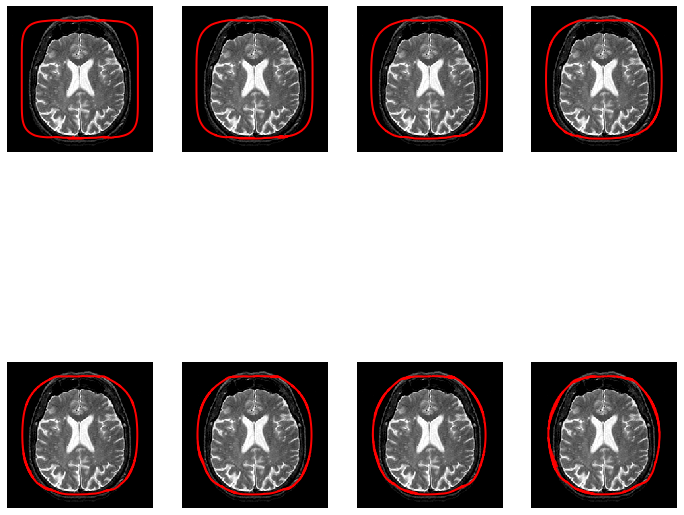

In [148]:
#Parameter
tau = 0.4
Tmax = 2000

nr,nc = new_I.shape
niter = int(Tmax/tau)
plt.figure(figsize=(12,12))
#we take phi0, so the first initialization contour
phi = np.copy(phi2)
k = 0
gwx,gwy = grad(W)
empirical = 10
for i in tqdm(range(1,niter+1)):
    gx,gy = grad(phi)
    eps = 10E-10
    n_phi = np.maximum(eps*np.ones([nr,nc]), np.sqrt(gx**2+gy**2))
    g_phix,g_phiy = gx/n_phi,gy/n_phi
    G = - W*n_phi*div(g_phix, g_phiy) + gx*gwx + gy*gwy
    phi = phi - tau*G
    if (i % 25) == 0:
        phi[-1,:] = eps*empirical #you can  pad to the original image so to have this phi = 0 ignored
        phi[0,:] = eps*empirical
        phi[:,0] = eps*empirical
        phi[:,-1] = eps*empirical
    if i % int(niter/8) == 0:
        print("Plotting ...")
        k += 1
        plt.subplot(2, 4, k)
        plot_levelset(phi[padnb:-padnb,padnb:-padnb],0,I_gray)

Multiple points can be noted: (and they are answered through example plotting above)
- First of all the fact that the approximation scheme for gradient is of second order unlike the active contour using euler equality
- very easily ill-conditioned which asks for retuning many times for different objects
- From the two different examples we created, we also noticed that initialization was very much important, and from that we can sort of guess a non isotropic attraction to bounds since when initialization is inside the desired contour, the end contour does not match the desired contour
- Smoothness of bounds again depends on the way we approximate the gradient image
- As we can see from above example, the contour was stuck in a local minima, and thus on the left and right side, the bounds are not closing up to the targeted part
- Below we did some comparison with active contour euler equality to test out the time but also the effectiveness and sensitivity to initialization (Potentially do if have time)